In [1]:
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import os
import requests
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import json

from nba_api.stats.endpoints import LeagueLeaders#pip install nba_api
! pip install --upgrade nbformat

   ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
   ---------- ----------------------------- 20.5/78.5 kB 640.0 kB/s eta 0:00:01
   ---------------------------------------- 78.5/78.5 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.10.3
    Uninstalling nbformat-5.10.3:
      Successfully uninstalled nbformat-5.10.3


In [4]:
datos = LeagueLeaders(
        league_id = '00', # nba 00, g_league 20, wnba 10
        season = 'All Time', # change year(s) if needed
        per_mode48 = 'Totals', # "Totals", "Per48", "PerGame"
        )
datos

In [2]:
def extraccion():
    ## Recogida y limpiado de datos

    datos = LeagueLeaders(
        league_id = '00', # nba 00, g_league 20, wnba 10
        season = 'All Time', # change year(s) if needed
        per_mode48 = 'Totals', # "Totals", "Per48", "PerGame"
        )
    return datos

In [7]:
def transform(datos):
    df = datos.get_data_frames()[0]
    #seleccionamos las columnas que queremos limpiando los nan
    df =df[['PLAYER_ID','PLAYER_NAME', 'GP', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS']].fillna(0)
    #Quitamos los valores que no tienen nombre
    df = df[~(df['PLAYER_NAME']==0)|(df['PLAYER_NAME']=="0")]
    
    return df

,PLAYER_ID,PLAYER_NAME,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,2544,LeBron James,1492,56596.0,14837,29313,0.506,2410.0,6926.0,0.348,...,0.736,1727.0,9458.0,11185.0,11009,2275.0,1111.0,5211.0,2682,40474
1,76003,Kareem Abdul-Jabbar,1560,57446.0,15837,28307,0.559,1.0,18.0,0.056,...,0.721,2975.0,9394.0,17440.0,5660,1160.0,3189.0,2527.0,4657,38387
2,252,Karl Malone,1476,54852.0,13528,26210,0.516,85.0,310.0,0.274,...,0.742,3562.0,11406.0,14968.0,5248,2085.0,1145.0,4524.0,4578,36928
3,977,Kobe Bryant,1346,48643.0,11719,26200,0.447,1827.0,5546.0,0.329,...,0.837,1499.0,5548.0,7047.0,6306,1944.0,640.0,4010.0,3353,33643
4,893,Michael Jordan,1072,41010.0,12192,24537,0.497,581.0,1778.0,0.327,...,0.835,1668.0,5004.0,6672.0,5633,2514.0,893.0,2924.0,2783,32292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,78470,Stan Washington,1,4.0,0,1,0.000,0.0,0.0,0.000,...,0.000,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0
4894,204033,David Wear,2,7.0,0,2,0.000,0.0,1.0,0.000,...,0.000,2.0,0.0,2.0,1,0.0,0.0,0.0,1,0
4895,203091,Royce White,3,9.0,0,1,0.000,0.0,0.0,0.000,...,0.000,0.0,0.0,0.0,0,0.0,0.0,0.0,2,0
4896,204222,Greg Whittington,4,12.0,0,3,0.000,0.0,2.0,0.000,...,0.000,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0


In [4]:
def load_air(df):
    #Utilizar requests
    #Subida de datos
    #Cambiar .env

    load_dotenv()
    #Subida de datos

    API_KEY = os.getenv("NBA_API_KEY")#Archivo .env con tu API KEY correspondiente

    BASE_ID = "app8OMeMKvRONnvjm" # Base: Tabla API #Cambiar a cada uno la suya

    TABLE_ID = "tblH644WbF42sjiBh" # Tabla: datos_1 #Cambiar a cada uno la suya
    
    airtable_base_url = "https://api.airtable.com/v0"

    headers = {"Authorization": f"Bearer {API_KEY}",
                "Content-Type": "application/json"}


    endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID}"
    
    #Bucle para subir todos los archivos a airtable utilizando offset
    offset = 0
    
    while offset < len(df):

        print(f"Subiendo datos {offset} a {offset+10} de {len(df)}")

        records = {"records" : []}

        df_temp = df.iloc[offset:offset+10]    
        for i in range(df_temp.shape[0]):

            fila = {"fields" : df_temp.iloc[i].dropna().to_dict()}

            records["records"].append(fila)

        response = requests.post(url = endpoint, json = records, headers = headers)
        print(f"response: {response.status_code}")

        offset += 10
        


In [5]:
def extraccion_air():
    
    load_dotenv()

    API_KEY = os.getenv("NBA_API_KEY")#Archivo . env von tu API KEY correspondiente

    BASE_ID = "app8OMeMKvRONnvjm" # Base: Tabla API #Cambiar a cada uno la suya

    TABLE_ID = "tblH644WbF42sjiBh" # Tabla: datos_1 #Cambiar a cada uno la suya
    
    
    endpoint = f"https://api.airtable.com/v0/{BASE_ID}/{TABLE_ID}"
    
    headers = {"Authorization": f"Bearer {API_KEY}",
                "Content-Type": "application/json"}
    #Descarga de datos por airtable con bucle

    params = {}


    datos = list()

    while params.get("offset") != None or len(datos) == 0:

        response = requests.get(url = endpoint, headers = headers, params = params)

        #print(f"response: {response.status_code}")
        #print(f"endpoint: {response.url}")

        data = response.json()

        offset = data.get("offset")

        params["offset"] = offset

        datos.extend(data["records"])
        
        df = pd.DataFrame([record['fields'] for record in datos])
        
    
    return df

In [6]:
def visualizacion(df):
    
#### Sunburst todas las variables que no sean player e id
    
    dfs = []  # Inicialización de dfs como una lista vacía
    
    categorias = {
        'Estadísticas ofensivas': ['PTS', 'FGM', 'FGA', 'FG_PCT', 'FTM', 'FTA', 'FT_PCT', 'FG3A', 'FG3M', 'FG3_PCT'],
        'Estadísticas defensivas': ["REB", 'DREB', 'OREB', 'STL', 'BLK'],
        'Otros': ['AST', 'TOV', 'PF', 'MIN', 'GP']
    }

    for categoria, subcategorias in categorias.items():
        for subcategoria in subcategorias:
            dfs.append(pd.DataFrame({'Categoría': categoria, 'Subcategoría': subcategoria, 'Valor': [df[subcategoria].sum()]}))

    # Concatenamos los DataFrames
    df_sunburst = pd.concat(dfs, ignore_index=True)

    # Gráfico de sunburst
    fig = px.sunburst(df_sunburst, path=['Categoría', 'Subcategoría'], values='Valor')
    fig.show()
    
#### Visualización con Matplotlib Top Anotadores
    top_anotadores = df.sort_values("PTS", ascending = False).head(20)
    plt.figure(figsize=(10, 6))
    plt.bar(top_anotadores['PLAYER_NAME'], top_anotadores['PTS'], color='skyblue')
    plt.xlabel('Jugador')
    plt.ylabel('Puntos')
    plt.title('Máximos anotadores de la historia')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.show()
    
####pts por minuto
    anot = df.sort_values("PTS", ascending=False).head(20)
    anot["Puntos/Min"] = anot["PTS"] / anot["MIN"]

    # Crear la gráfica de barras
    fig = px.bar(anot, x='PLAYER_NAME', y='Puntos/Min', title='Top Anotadores, Puntos/Minuto')
    fig.update_xaxes(title_text='Jugadores')  # Renombrar el título del eje x
    fig.show()
####pts por partido
    anot = df.sort_values("PTS", ascending=False).head(20)
    anot["Puntos/Partido"] = anot["PTS"] / anot["GP"]

    # Crear la gráfica de barras
    fig = px.bar(anot, x='PLAYER_NAME', y='Puntos/Partido', title='Top Anotadores, Puntos/Partido')
    fig.update_xaxes(title_text='Jugadores')  # Renombrar el título del eje x
    fig.show()
    
####Top Asistencias
    max_reb = df.sort_values("AST", ascending = False).head(15)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='PLAYER_NAME', y='AST', data=max_reb, palette='viridis', hue ='PLAYER_NAME' )
    plt.title('Top 15 Asistencias')
    plt.xlabel('Jugador')
    plt.ylabel('Asistencias')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
####Top Reboteadores 
    max_reb = df.sort_values("REB", ascending = False).head(15)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='PLAYER_NAME', y='REB', data=max_reb, palette='coolwarm', hue ='PLAYER_NAME' )
    plt.title('Top 15 Reboteadores')
    plt.xlabel('Jugador')
    plt.ylabel('Número de Rebotes')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
####Distribución % Tiros de 3
    sns.set_style("whitegrid")
    sns.set_palette("pastel")

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x="FG3_PCT", bins=25, kde=True)

    plt.title('Distribución del % de Tiros Triples')
    plt.xlabel('% de Tiros Triples')
    plt.ylabel('Nº de Jugadores')

    plt.grid(axis='y')
    
    # línea vertical para la media
    mean_fg_pct = df['FG3_PCT'].mean()
    plt.axvline(x=mean_fg_pct, color='red', linestyle='--', label=f'Media: {mean_fg_pct:.2f}')
    
    plt.legend()
    plt.show()
    
####Distribución % Tiros de 2
    sns.set_style("dark")
    sns.set_palette("muted")

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x="FG_PCT", bins=25, kde=True)

    plt.title('Distribución del % de Tiros de Campo')
    plt.xlabel('% de Tiros de Campo')
    plt.ylabel('Nº de Jugadores')

    plt.grid(axis='y')
    
    # línea vertical para la media
    mean_fg_pct = df['FG_PCT'].mean()
    plt.axvline(x=mean_fg_pct, color='red', linestyle='--', label=f'Media: {mean_fg_pct:.2f}')
    
    plt.legend()
    plt.show()

####Distribución % Tiros de 1
    sns.set_style("ticks")
    sns.set_palette("husl")

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x="FT_PCT", bins=25, kde=True)

    plt.title('Distribución del % de Tiros Libres')
    plt.xlabel('% de Tiros Libres')
    plt.ylabel('Nº de Jugadores')

    plt.grid(axis='y')
    
    # línea vertical para la media
    mean_fg_pct = df['FT_PCT'].mean()
    plt.axvline(x=mean_fg_pct, color='red', linestyle='--', label=f'Media: {mean_fg_pct:.2f}')
    
    plt.legend()
    plt.show()
    

#### Correlación Tiros de tres intentados
    
    columnas = ['FTA','FGA', 'FG3A']

    # Calcula la matriz de correlación
    correlation_matrix = df[columnas].corr()

    # Configura el heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='BrBG', fmt=".2f", linewidths=.5)
    plt.title('Correlación Total Intentos Tiros Libres, Tiros de Campo y Tiros de Tres Puntos')
    plt.show()
    
    ## Correlación Tiros de tres encestados
    # Selecciona las columnas relevantes
    columnas = ['FTM', 'FGM', 'FG3M']

    # Calcula la matriz de correlación
    correlation_matrix = df[columnas].corr()

    # Configura el heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlación Acierto Tiros Libres, Tiros de Campo y Tiros de Tres Puntos')
    plt.show()
    
    
#####Top Defensores de la historia
    #Puntaje_Defensa=REB+(2xBLK)+(2×STL)
    df['Puntaje_Defensa'] = df['REB'] + (2*df['BLK']) + (2*df['STL'])
    #Puntaje_Ataque = PTS + AST - TOV - (0.5x(FTA-FTM))- (0.5x(FGA-FGM))- (0.5x(FG3A-FG3M))
    df['Puntaje_Ataque'] = df['PTS'] + df['AST'] - df["TOV"] - (0.5*(df["FTA"]-df["FTM"]))-(0.5*(df["FGA"]-df["FGM"]))-(0.5*(df["FG3A"]-df["FG3M"]))

    # Ordenar los jugadores según su puntaje de defensa en orden descendente
    df = df.sort_values('Puntaje_Defensa',ascending=False)
    fig = px.bar(df.head(20), x='PLAYER_NAME', y='Puntaje_Defensa', title='Top Defensores de la historia')
    fig.update_xaxes(title_text="Puntaje_Defensa=REB+(2xBLK)+(2×STL)")  # Renombrar el título del eje x
    fig.update_yaxes(title_text='Puntaje Defensa')  # Renombrar el título del eje y
    
    fig.show()
    
########Ataque de los Mejores Defensores
        # Ordenar los jugadores según su puntaje de defensa en orden descendente
    df = df.sort_values('Puntaje_Defensa', ascending=False)

    # Crear la gráfica de barras
    fig = px.bar(df.head(20), x='PLAYER_NAME', y='Puntaje_Ataque', title='Puntaje de Ataque de los Mejores Defensores')

    # Actualizar el nombre del eje x
    fig.update_xaxes(title_text='Jugadores')

    fig.show()

######Top Atacantes de la historia

        # Ordenar los jugadores según su puntaje de defensa en orden descendente
    df_top_atacantes = df.sort_values('Puntaje_Ataque', ascending=False).head(20)

        # Crear el gráfico con Plotly Express
    fig = px.bar(df_top_atacantes.head(20), x='PLAYER_NAME', y='Puntaje_Ataque', title='Top Atacantes de la historia')
    fig.update_xaxes(title_text="Puntaje_Ataque = PTS + AST - TOV - (0.5x(FTA-FTM))- (0.5x(FGA-FGM))- (0.5x(FG3A-FG3M))")  # Renombrar el título del eje x

    fig.show()
##### Mejores atacantes en defensa 
    fig = px.bar(df_top_atacantes.head(20), x='PLAYER_NAME', y='Puntaje_Defensa', title='Puntaje de Defensa de los Mejores Atacantes')

    fig.update_xaxes(title_text='Jugadores')
    
    fig.show()
    
#####Distribución logaritmica Puntos Anotados en función de los Minutos Jugados

    #Establemcemos un umbral de minutos y puntos para eliminar a jugadores que sólo han jugado menos 10 minutos en su carrera o han anotado menos de 10 puntos
    umbral_minutos = 30
    umbral_puntos = 30 
    df_filtered = df[(df['MIN'] >= umbral_minutos) & (df['PTS'] >= umbral_puntos)]

    # Calcular los puntos por partido y el logaritmo neperiano de los puntos
    log_points = np.log(df_filtered['PTS'])

    # Graficar la distribución de los puntos anotados por partido utilizando un scatterplot
    plt.figure(figsize=(10, 6))
    plt.scatter( log_points, df_filtered['MIN'], color='skyblue', alpha=0.7)
    plt.title('Distribución logaritmica Puntos Anotados en función de los Minutos Jugados')
    plt.ylabel('Minutos Jugados')
    plt.xlabel('Logaritmo Neperiano de Puntos anotados')
    plt.grid(True)
    plt.show()
    
####Distribución de Puntos Anotados por partido y su frecuencia

    df_filtered = df[(df['MIN'] != 0) & (df['PTS'] != 0)]

    # Graficar la distribución de los puntos anotados por partido
    plt.figure(figsize=(10, 6))
    plt.hist(df_filtered['PTS'] / df_filtered['GP'], bins=30, edgecolor='black', alpha=0.7)
    plt.title('Distribución de Puntos Anotados y su frecuencia')
    plt.xlabel('Puntos Anotados por Partido')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()    

####Relación entre Minutos por partido y Puntos por partido
    #Posibilidad de filtrar entre un rango determinado de puntos
    df_filtered = df[(df['MIN'] != 0) & (df['PTS'] != 0)]
    #Posibilidad de filtrar entre un rango determinado de puntos
    df_pts_per_game = df_filtered[(df_filtered["PTS"]/df_filtered["GP"]).between(0.1, 40)]

    #Grafica
    fig = px.scatter(data_frame=df_pts_per_game,
                    y=df_pts_per_game["MIN"]/df_pts_per_game["GP"],
                    x=df_pts_per_game["PTS"]/df_pts_per_game["GP"],
                    labels={'x': 'Puntos por partido', 'y': 'Minutos por partido'},
                    color="MIN",
                    hover_name="PLAYER_NAME",
                    title="Relación entre Minutos por partido y Puntos por partido",
                    opacity=0.5)
    fig.show()
    

                                                    PROYECTO ETL NBA                                                    


*************************************************EXTRACCION*COMPLETADA**************************************************


***********************************************TRANSFORMACION*COMPLETADA************************************************
Subiendo datos 0 a 10 de 4894
response: 200
Subiendo datos 10 a 20 de 4894
response: 200
Subiendo datos 20 a 30 de 4894
response: 200
Subiendo datos 30 a 40 de 4894
response: 200
Subiendo datos 40 a 50 de 4894
response: 200
Subiendo datos 50 a 60 de 4894
response: 200
Subiendo datos 60 a 70 de 4894
response: 200
Subiendo datos 70 a 80 de 4894
response: 200
Subiendo datos 80 a 90 de 4894
response: 200
Subiendo datos 90 a 100 de 4894
response: 200
Subiendo datos 100 a 110 de 4894
response: 200
Subiendo datos 110 a 120 de 4894
response: 200
Subiendo datos 120 a 130 de 4894
response: 200
Subiendo datos 130 a 140 de 4894
response:

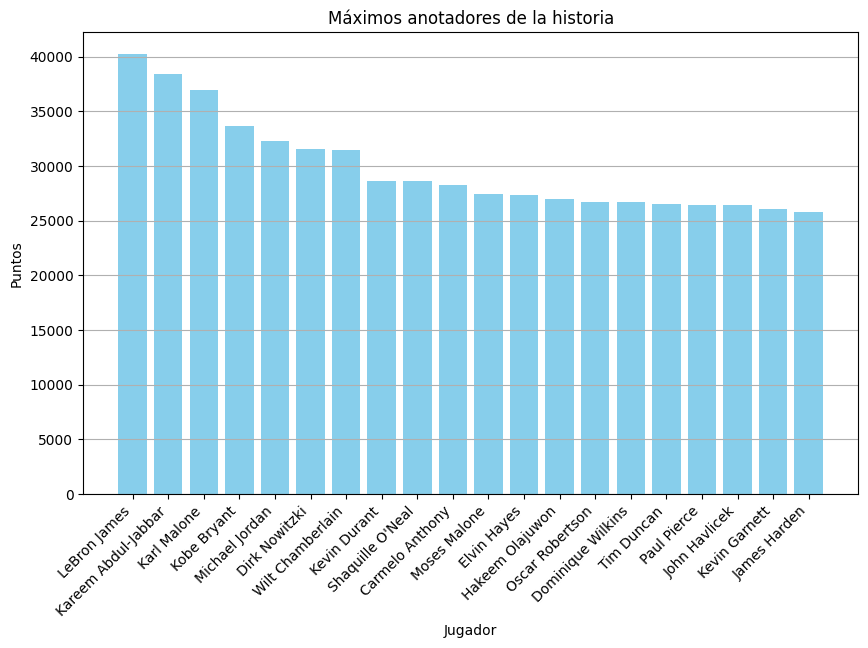

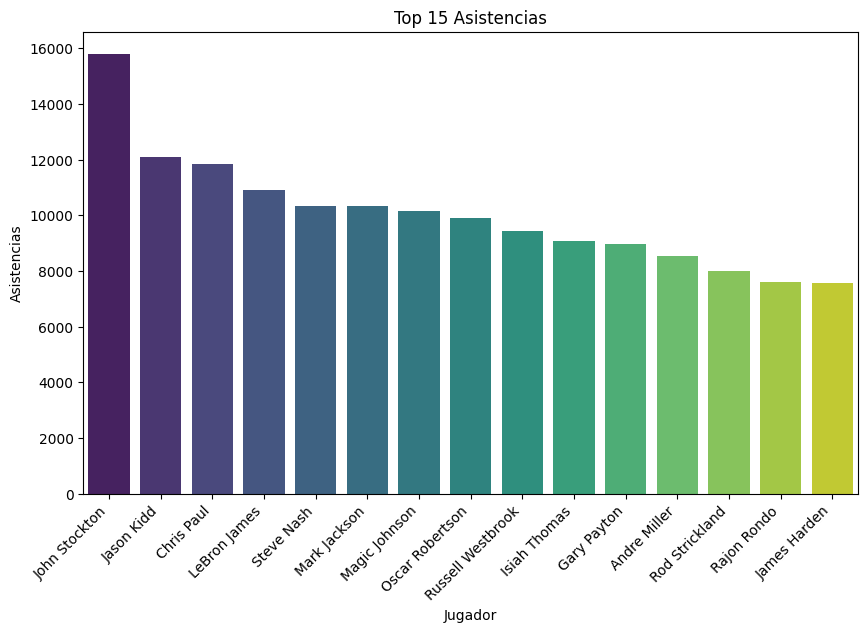

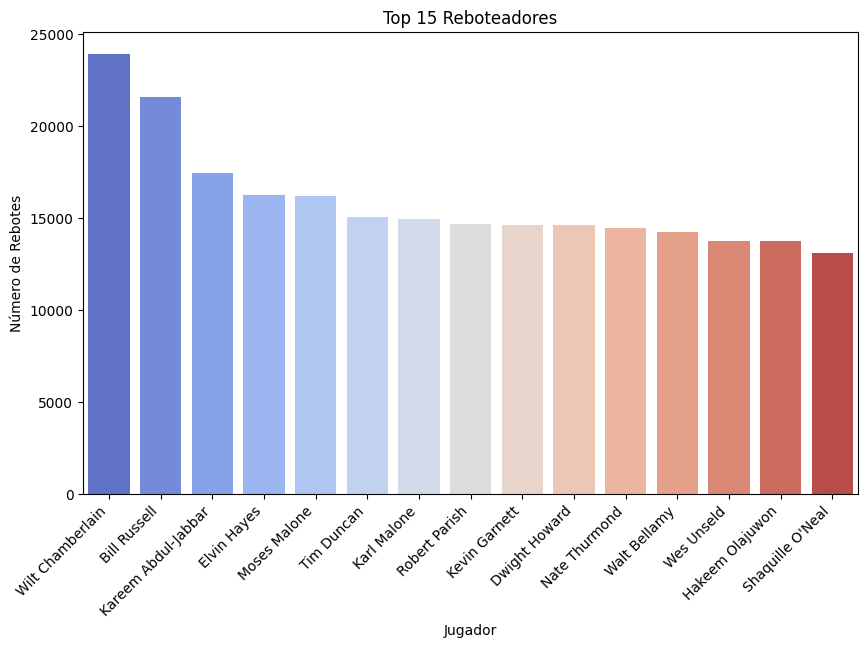

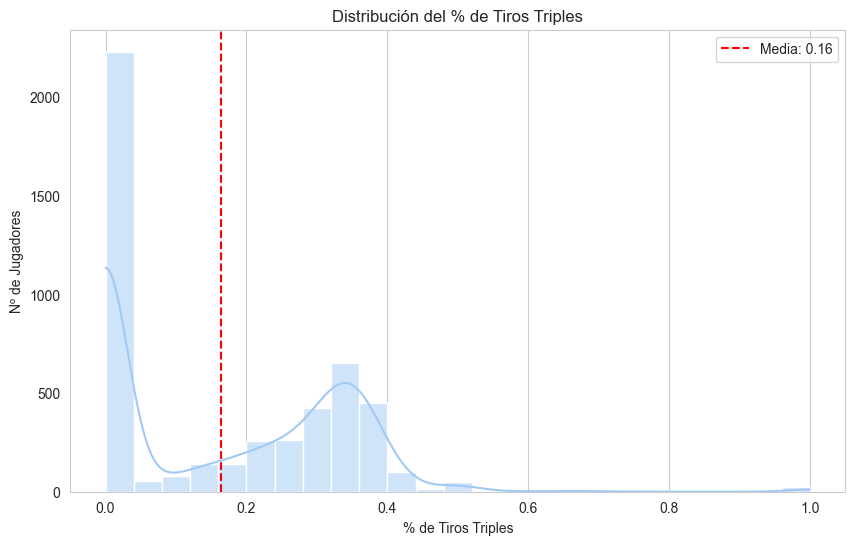

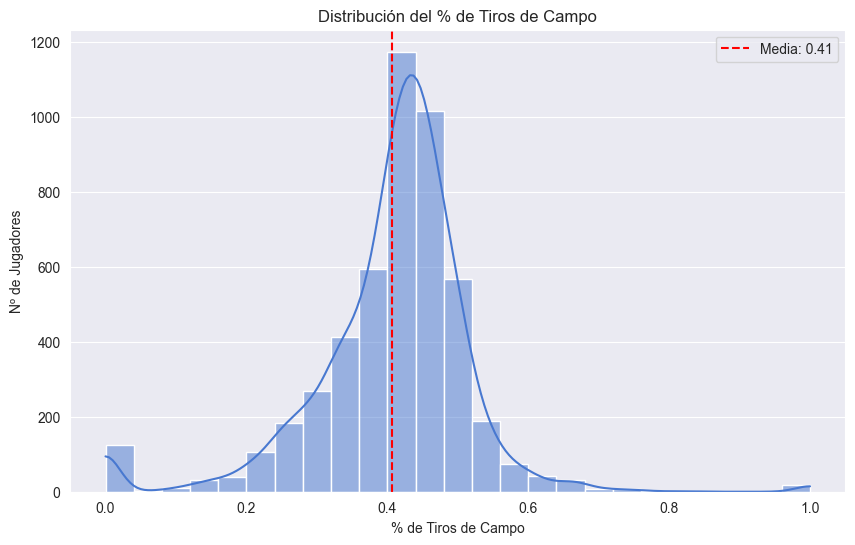

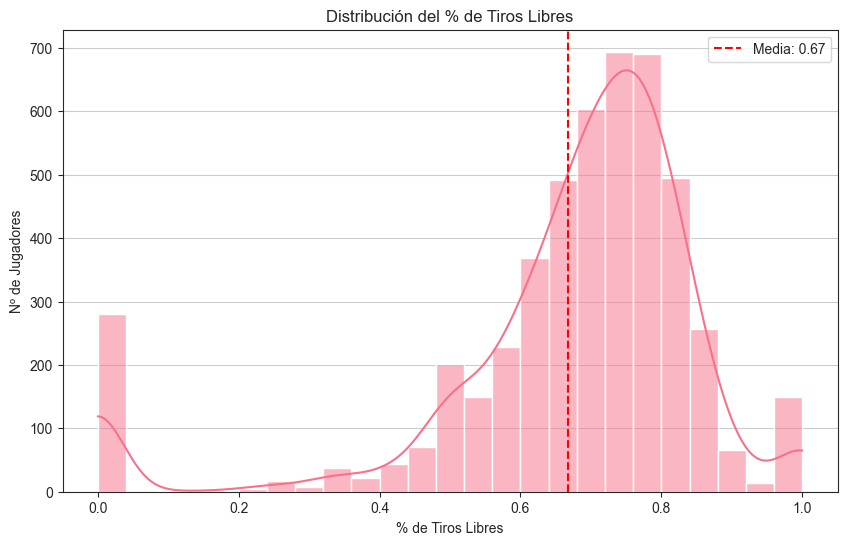

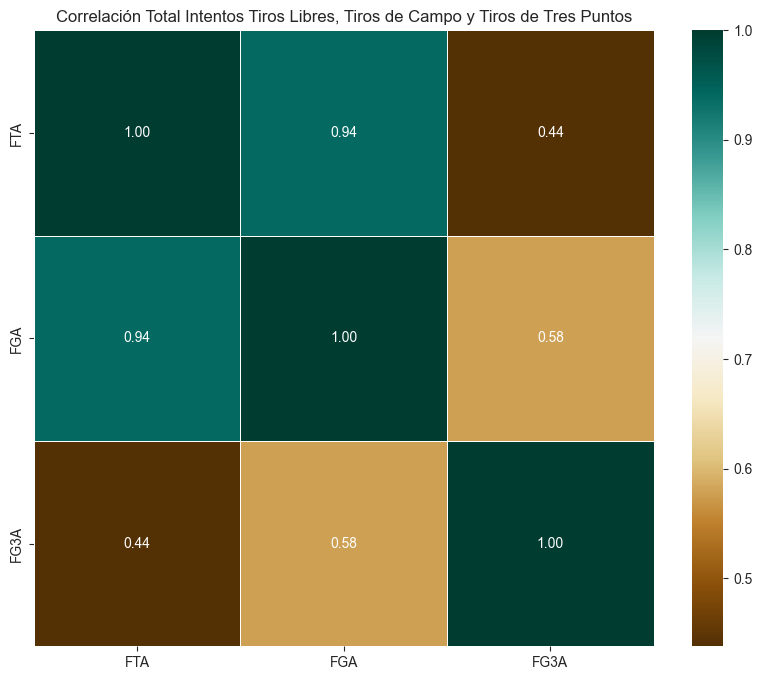

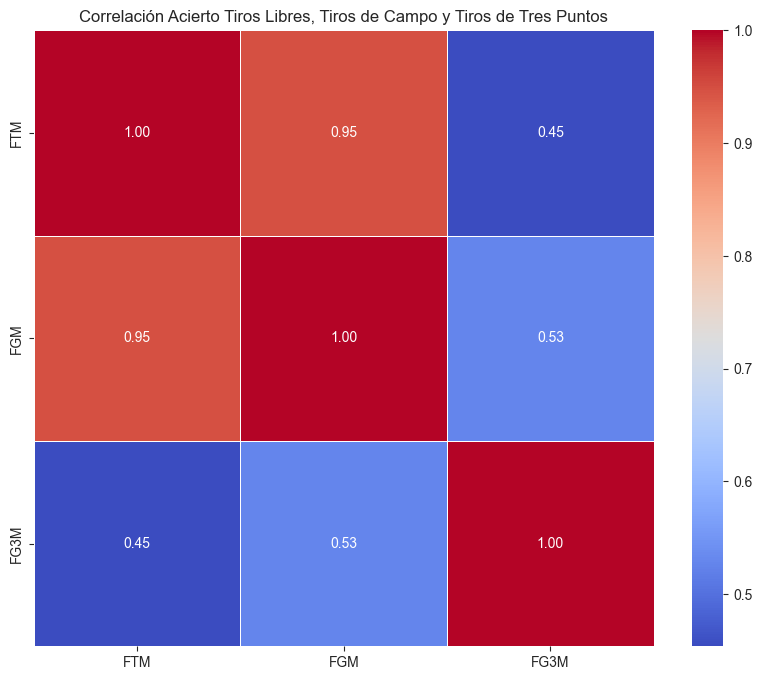

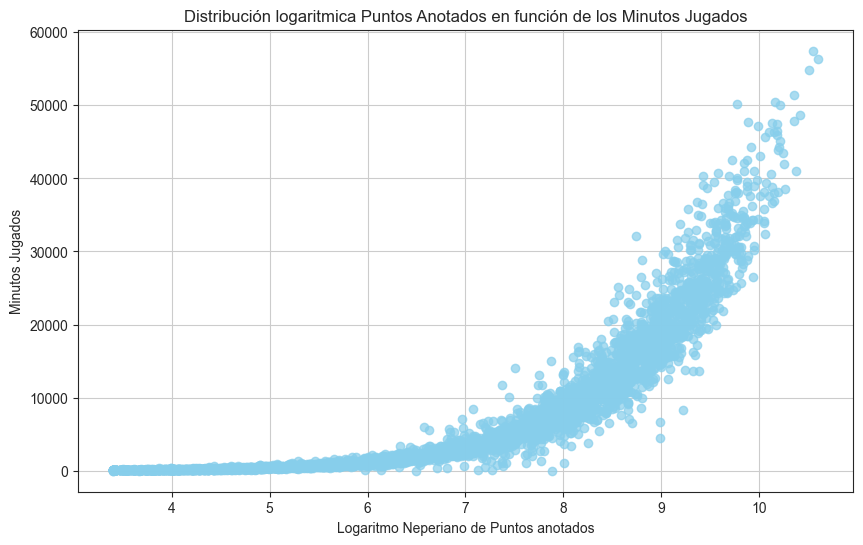

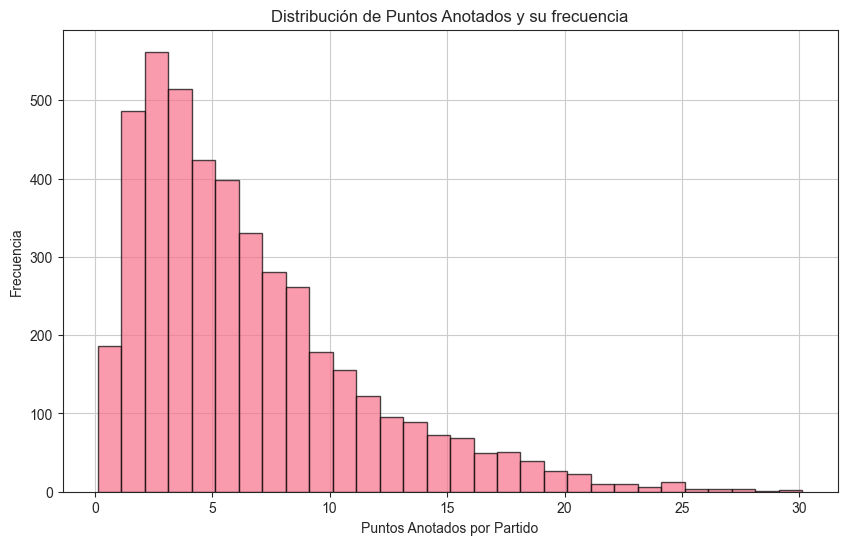

************************************************VISUALIZACION*COMPLETADA************************************************


                                                          FIN                                                           


In [7]:
def main():
    print("PROYECTO ETL NBA".center(120))
    print("\n")
    datos = extraccion()
    print("EXTRACCION COMPLETADA".center(120).replace(" ","*"))
    print("\n")
    df_transformado = transform(datos)
    print("TRANSFORMACION COMPLETADA".center(120).replace(" ","*"))
    load_air(df_transformado)
    print("SUBIDA A AIRTABLE COMPLETADA".center(120).replace(" ","*"))
    print("\n")
    df_cargado = extraccion_air()
    print("EXTRACCION DE AIRTABLE COMPLETADA".center(120).replace(" ","*"))
    visualizacion(df_cargado)
    print("VISUALIZACION COMPLETADA".center(120).replace(" ","*"))
    print("\n")
    print("FIN".center(120))

if __name__ == "__main__":
    main()